# TRABALHO 5 - Corners e Rastreamento

#### 1. Implemente uma função para detectar pontos Harris em uma imagem.

Em visão computacional, a detecção de features (bordas, cantos e pontos de interesse) é uma tarefa de extrema importância, pois serve como base para diversas aplicações, como structure from motion, criação de mosaicos, detecção de objetos, entre outras. O algoritmo de Harris é uma técnica utilizada para a detecção de cantos (corners), identificando regiões onde a intensidade dos pixels varia significativamente em pelo menos duas direções, como em interseções de bordas. O método utiliza uma matriz de autocorrelação para analisar essas variações, e os autovalores dessa matriz indicam a "força" do canto, ajudando a determinar se ele é uma boa feature ou não.

In [3]:
# Importação de bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import cv2 

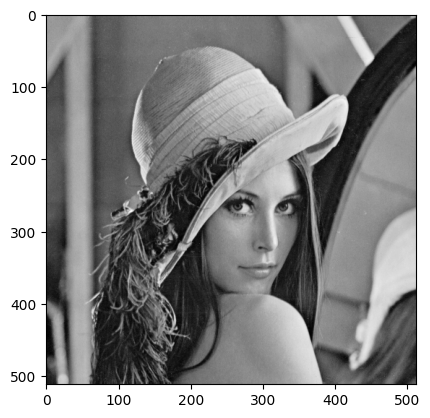

In [4]:
# Importando uma imagem
img = cv2.imread('/home/ramon/projects/visao/images/Lenna.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

A função abaixo implementa o algoritmo de detecção de corners de Harris em uma imagem, retornando os cantos detectados. Primeiro, calcula-se os gradientes horizontais e verticais da imagem, utilizados para construir os elementos da matriz de Harris. Em seguida, para cada pixel, o algoritmo computa o valor de R, que representa a "força" de um canto, usando o determinante e o traço da matriz de Harris. Esses valores são armazenados em uma matriz e normalizados. Um threshold é aplicado para selecionar candidatos a cantos, e por último, o Non Maximum Suppression é utilizado para garantir que apenas os máximos locais em uma região específica sejam mantidos como cantos válidos. A função retorna uma lista de cantos detectados com suas respectivas coordenadas e valores de R.

In [5]:
def find_harris_corners(img, window_size=3, k=0.04, threshold=0.1, nms_window=50):

    # Cria uma lista vazia para armazenar os corners
    corners = []
    offset = window_size // 2
    # Matriz para armazenar os valores de R de cada pixel
    r_matrix = np.zeros_like(img, dtype=np.float32)

    # Calcula os gradientes da imagem
    dy, dx = np.gradient(img)
    # Calcula os elementos da matriz de Harris
    ix2 = dx**2
    iy2 = dy**2
    ixy = dx*dy

    # Calcula a soma dos elementos da matriz de Harris em torno de um pixel
    for i in range(offset, img.shape[0] - offset):
        for j in range(offset, img.shape[1] - offset):
            sx2 = np.sum(ix2[i-offset:i+offset+1, j-offset:j+offset+1])
            sy2 = np.sum(iy2[i-offset:i+offset+1, j-offset:j+offset+1])
            sxy = np.sum(ixy[i-offset:i+offset+1, j-offset:j+offset+1])
            
            # Calcula o determinante e o traço da matriz de Harris
            det = sx2 * sy2 - sxy**2
            trace = sx2 + sy2

            # Calcula o valor de R para o pixel
            r = det - k * (trace**2)
            r_matrix[i, j] = r

    # Normaliza a matriz R
    r_matrix = r_matrix / np.max(r_matrix)

    # Aplica um threshold para encontrar obons candidatos a corners
    corners = np.argwhere(r_matrix > threshold)
    corners = [(i, j, r_matrix[i, j]) for i, j in corners]

    nms_offset = nms_window // 2
    suppressed_corners = []

    # Aplica o Non Maximum Supression, deixando apenas os máximos locais
    for i, j, r in corners:
        if r == np.max(r_matrix[max(0, i-nms_offset):i+nms_offset+1, max(0, j-nms_offset):j+nms_offset+1]):
            suppressed_corners.append((i, j, r))

    return suppressed_corners

In [6]:
# Encontra os corners de Harris na imagem
corners = find_harris_corners(gray, 5, 0.04, 0.04)

Abaixo são exibidos os pontos obtidos com o algoritmo de Harris.

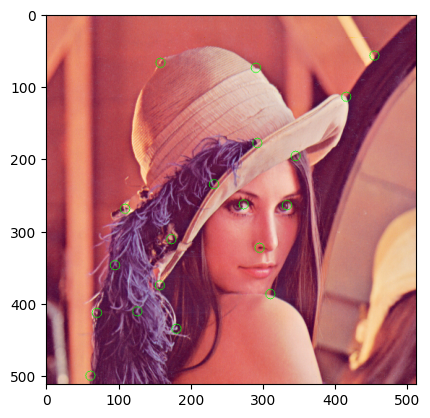

In [7]:
# Cria uma cópia da imagem para desenhar os corners
copy = img.copy()

# Desenha os corners na imagem
for corner in corners:
    x, y, _ = corner
    cv2.circle(copy, (int(y), int(x)), 7, (0, 255, 0), 0)

# Exibe a imagem com os corners encontrados
copy = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)
plt.imshow(copy)

#### 2. Sendo a entrada de uma função os pontos detectados no passo anterior, implemente uma função para realizar o rastreamento destes pontos (detectá-los em uma segunda imagem).

A função abaixo realiza a correspondência de pontos de interesse (template matching) entre duas imagens, utilizando como base uma lista de cantos fornecida. Para cada canto na primeira imagem, a função extrai uma janela quadrada de tamanho definido ao redor do ponto de interesse e realiza uma busca exaustiva na segunda imagem. Durante a busca, calcula-se a correlação normalizada com média subtraída entre o template extraído e todas as janelas da mesma dimensão na segunda imagem. O ponto com o maior valor de correlação é considerado o melhor ajuste para o canto em questão. A função retorna as coordenadas dos corners rastreados na segunda imagem.

In [21]:
def template_matching(img1, img2, corners, window_size=11):

    tracked_corners = []
    offset = window_size // 2

    for x, y in corners:
        x, y = int(x), int(y)

        # Extrai a janela em torno do ponto na primeira imagem
        template = img1[max(0, y-offset):y+offset+1, max(0, x-offset):x+offset+1]

        # Verifica se a janela é válida
        if template.shape != (window_size, window_size):  
            continue

        best_match = None
        best_corr = -np.inf  

        # Realiza a varredura na segunda imagem
        for ny in range(offset, img2.shape[0] - offset):
            for nx in range(offset, img2.shape[1] - offset):
                patch = img2[ny-offset:ny+offset+1, nx-offset:nx+offset+1]

                if patch.shape == template.shape:
                    # Correlação normalizada e com média subtraída
                    template_mean = np.mean(template)
                    patch_mean = np.mean(patch)
                    numerator = np.sum((template - template_mean) * (patch - patch_mean))
                    denominator = np.sqrt(np.sum((template - template_mean) ** 2) * np.sum((patch - patch_mean) ** 2))

                    corr = numerator / denominator if denominator > 0 else 0

                    # Verifica se é o melhor match
                    if corr > best_corr:
                        best_corr = corr
                        best_match = (nx, ny)

        # Garante que best_match é válido
        if best_match:
            tracked_corners.append(best_match)

    return tracked_corners

Como pode ser visto abaixo, o tempo necessário para "deslizar" o template por toda a imagem é bastante alto, pois o processo realiza uma busca exaustiva. Para otimizar esse tempo, é possível restringir o espaço de busca a um raio em torno das coordenadas do pixel na imagem original. Essa abordagem é baseada na suposição de que o ponto de interesse não sofreu um deslocamento significativo entre as imagens, como geralmente ocorre em quadros consecutivos de um vídeo.

In [26]:
# Cria uma cópia da imagem em tons de cinza
img2 = gray.copy()

# Corners da primeira imagem
corner_points = [(x, y) for x, y, _ in corners]

# Rastreia os pontos na segunda imagem
tracked_points = template_matching(gray, img2, corner_points)

Abaixo são exibidos os pontos rastreados na segunda imagem, que como pode ser observado, são os mesmos obtidos pelo algoritmo de Harris.

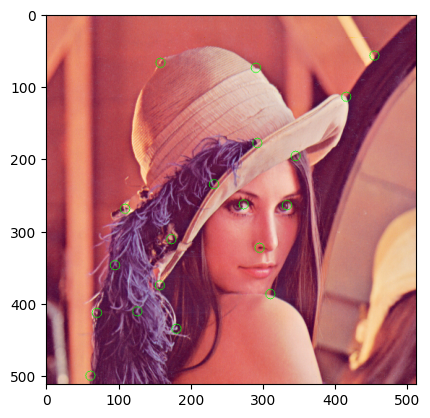

In [29]:
# Cria uma cópia da imagem para desenhar os corners
copy2 = img.copy()

# Desenha os corners na imagem
for point in tracked_points:
    x, y = point
    cv2.circle(copy2, (int(y), int(x)), 7, (0, 255, 0), 0)

# Exibe a imagem com os corners rastreados
copy2 = cv2.cvtColor(copy2, cv2.COLOR_BGR2RGB)
plt.imshow(copy2)